# Running linear models on DEA indices using Sentinel

**Background:** This document presents an example of applying a linear model to analyse Landsat data extracted from Digital Earth Australia (DEA) to make inferences about physical processes. Here we are testing the rate of decline in vegetation condition during the dry season in NW Australia. Rainfall in this part of Australia is highly seasonal. During the dry season (April to October) there is very little rain and we assume that soil moisture declines throughout.

A common approach for assessing the likelihood of vegetation being dependent on groundwater is applying the 'green island' principle. This involves inferring gorudnwater use from vegetation that maintains higher condition during dry periods. In our area of interest, we expect that vegetation condition will decline much more rapidly in vegetation communities that are wholly reliant on surface water compared to communities that access groundwater (i.e. groundwater dependent ecosystems). We use NDVI as a proxy for vegetation condition.


**What does this document do?**

- Retrieve Landsat data for temporal and spatial extents
- Calculate NDVI and groupby months
- Demonstrate how to build a linear model to analyse the rate of decay in NDVI throughout the dry season
- Plot linear model parameters and use spatial patterns to infer distribuition of potential GDEs

**Requirements**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date**: June 2019

**Authors**: Neil Symington, Robbi Bishop-Taylor, Bex Dunn

## Retrieving Landsat data
Here we import data Landsat data from the DEA. In our experience using the larger number of observations decreases our signal-to-noise ration and thus enables us to resolve landscape features at a higher resolution. Hence, for the actual data product we used the entire landsat archive and ran the processing through the raijin supercomputer.  However for this example we will only consider data from 2009-2019 from landsat 8.

### Import modules

In [1]:
%matplotlib inline
import sys
import warnings
import datacube
import matplotlib.pyplot as plt
from datacube.storage import masking
from datacube.helpers import write_geotiff
import calendar
import numpy as np
import xarray as xr

sys.path.append('/g/data/zk34/pxk547/dea-notebooks/10_Scripts/')
import DEADataHandling, DEAPlotting

# Dictoinary for mapping month number to months names 
mnths =dict((k,v) for k,v in enumerate(calendar.month_name) if k!= 0)


In [2]:
# Connect to a datacube
dc = datacube.Datacube(app='LinearModels')


In [3]:

def linregress_3D(x, y):
    """
    
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three 
    dimensions (time,lat,lon). 
    Datasets can be provided in any order, but note that the regression slope 
    and intercept will be calculated for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, 
    and standard error on regression between the two datasets along their 
    aligned time dimension.  
    """ 
    # Ensure that the data are properly aligned to each other. 
    x,y = xr.align(x,y)

    
    #Compute data length, mean and standard deviation along time axis: 
    n = y.notnull().sum(dim='month')
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)

    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)

    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #6. Compute regression slope and intercept:
    LRslope    = cov/(xstd**2)
    LRintercept = ymean - xmean*LRslope  

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = LRslope/tstats

    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,LRslope,LRintercept,pval,stderr,ystd

def regression_pixel_drill_ndvi(x, y, ax, slope, intercept, scatter_kwargs = None,
                          plot_kwargs = None):
    """
    Function  for plotting regression points and line on an axis
    @param x: x coordinate
    @param y: y coordinate
    @param ax: matplotlib axis
    @param scatter_kwargs: matplotlib keyword arguments for a scatter plot
    @param plot_kwargs: matplotlib keyword arguments for a plot
    """
    ndvi_pt = ndvi_dry.sel(x = x, y = y,
                           method = 'nearest').values
    months = ndvi_dry.month.values
    
    ax.scatter(months, ndvi_pt, **scatter_kwargs)
    
    # Get the slope and intercepth
    
    slope_ = slope.sel(x = x, y = y,
                       method = 'nearest').values
    
    intercept_ = intercept.sel(x = x, y = y,
                       method = 'nearest').values
    # Add a line to the graph
    
    xs = np.array([months[0], months[-1]])

    ys = np.array([slope_*v + intercept_ for v in xs])
    
    # Plot the line on the axis
    
    ax.plot(xs, ys, **plot_kwargs)
    
def regression_pixel_drill_ndmi(x, y, ax, slope, intercept, scatter_kwargs = None,
                          plot_kwargs = None):
    """
    Function  for plotting regression points and line on an axis
    @param x: x coordinate
    @param y: y coordinate
    @param ax: matplotlib axis
    @param scatter_kwargs: matplotlib keyword arguments for a scatter plot
    @param plot_kwargs: matplotlib keyword arguments for a plot
    """
    ndmi_pt = ndmi_dry.sel(x = x, y = y,
                           method = 'nearest').values
    months = ndmi_dry.month.values
    
    ax.scatter(months, ndmi_pt, **scatter_kwargs)
        
    slope_ = slope.sel(x = x, y = y,
                       method = 'nearest').values
    
    intercept_ = intercept.sel(x = x, y = y,
                       method = 'nearest').values
    # Add a line to the graph
    
    xs = np.array([months[0], months[-1]])

    ys = np.array([slope_*v + intercept_ for v in xs])
    
    # Plot the line on the axis
    
    ax.plot(xs, ys, **plot_kwargs)
    
def regression_pixel_drill_ndwi(x, y, ax, slope, intercept, scatter_kwargs = None,
                          plot_kwargs = None):
    """
    Function  for plotting regression points and line on an axis
    @param x: x coordinate
    @param y: y coordinate
    @param ax: matplotlib axis
    @param scatter_kwargs: matplotlib keyword arguments for a scatter plot
    @param plot_kwargs: matplotlib keyword arguments for a plot
    """
    ndwi_pt = ndwi_dry.sel(x = x, y = y,
                           method = 'nearest').values
    months = ndwi_dry.month.values
    
    ax.scatter(months, ndwi_pt, **scatter_kwargs)
    
    # Get the slope and intercepth
    
    slope_ = slope.sel(x = x, y = y,
                       method = 'nearest').values
    
    intercept_ = intercept.sel(x = x, y = y,
                       method = 'nearest').values
    # Add a line to the graph
    
    xs = np.array([months[0], months[-1]])

    ys = np.array([slope_*v + intercept_ for v in xs])
    
    # Plot the line on the axis
    
    ax.plot(xs, ys, **plot_kwargs)   

In [234]:
# Create spatial and temporal query

#query to do with springs
query = {'lat': (-19.786, -19.6765),
         'lon': (145.32, 145.42),
         'time':('2000-01-01','2010-01-01')} #'time':('1990-01-01','2000-01-01')} #'time':('2015-10-22', '2019-01-10')}

#query to do with oval  - NDMI median points were all over the place, and correlation low, so think R2 should be high
#query = {'lat': (-19.785, -19.725),
#         'lon': (145.95, 146.01),
#         'time':('2005-10-22', '2019-01-10')}

#'time':('1980-01-01', '2019-01-10')}

# Define query coordinate reference system

query['crs'] = 'EPSG:4326'
query['output_crs'] = 'EPSG:28355'
query['resolution'] = (25.,25.)


In [235]:
# Load data for the specified query extent using `dc.load`:
ds = dc.load(product='ls8_nbar_albers', group_by='solar_day', **query
            )
ds

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

## Adding code in to extract cloud free data only (from stacked plot script)

In [236]:
#set cloudmasking threshold and load landsat nbart data
landsat_masked_prop = 0.90
ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart', masked_prop=landsat_masked_prop)


Loading ls5
    Loading 61 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 43 filtered ls7 timesteps
Loading ls8
    Skipping ls8; no valid data for query
Combining and sorting ls5, ls7 data
    Replacing invalid -999 values with NaN (data will be coerced to float32)


In [237]:
ls578_ds

<xarray.Dataset>
Dimensions:    (time: 104, x: 425, y: 489)
Coordinates:
  * y          (y) float64 7.811e+06 7.811e+06 7.811e+06 ... 7.824e+06 7.824e+06
  * x          (x) float64 3.239e+05 3.239e+05 3.239e+05 ... 3.345e+05 3.345e+05
  * time       (time) datetime64[ns] 2000-01-21T00:09:59.500000 ... 2009-12-07T00:07:44.500000
Data variables:
    blue       (time, y, x) float32 346.0 363.0 413.0 ... 761.0 788.0 840.0
    green      (time, y, x) float32 804.0 806.0 807.0 ... 1107.0 1132.0 1125.0
    red        (time, y, x) float32 683.0 685.0 685.0 ... 1381.0 1377.0 1435.0
    nir        (time, y, x) float32 2980.0 2986.0 2952.0 ... 2286.0 2301.0
    swir1      (time, y, x) float32 1984.0 2010.0 2012.0 ... 3354.0 3409.0
    swir2      (time, y, x) float32 1070.0 1073.0 1074.0 ... 2474.0 2565.0
    data_perc  (time, y, x) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    crs:      EPSG:28355

In [238]:
ls578_ds.isel(time=9)

<xarray.Dataset>
Dimensions:    (x: 425, y: 489)
Coordinates:
  * y          (y) float64 7.811e+06 7.811e+06 7.811e+06 ... 7.824e+06 7.824e+06
  * x          (x) float64 3.239e+05 3.239e+05 3.239e+05 ... 3.345e+05 3.345e+05
    time       datetime64[ns] 2000-11-20T00:07:31.500000
Data variables:
    blue       (y, x) float32 331.0 332.0 332.0 332.0 ... 496.0 510.0 507.0
    green      (y, x) float32 544.0 577.0 577.0 577.0 ... 736.0 702.0 731.0
    red        (y, x) float32 516.0 531.0 517.0 545.0 ... 844.0 828.0 838.0
    nir        (y, x) float32 2083.0 2052.0 1984.0 ... 2159.0 2120.0 2040.0
    swir1      (y, x) float32 1799.0 1841.0 1784.0 ... 2688.0 2643.0 2571.0
    swir2      (y, x) float32 992.0 1035.0 1076.0 ... 1761.0 1819.0 1728.0
    data_perc  (y, x) float32 0.9963046 0.9963046 ... 0.9963046 0.9963046
Attributes:
    crs:      EPSG:28355

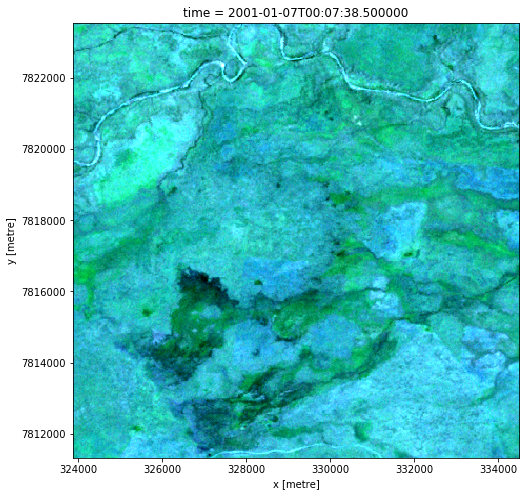

In [239]:
# View the rgb image

ls578_ds[['blue','green', 'red']].isel(time=10).to_array().plot.imshow(robust=True, figsize=(8,8))



Our study area is the margin of a sandy, unconfined aquifer system to the south and mud flats to the north. In the middle of the area are a number of 'islands' of thick vegetation (dark green). We want to assess the likelihood of these communities having some degree of groudnwater water dependence.

In [240]:
# Calculate NDVI and NDMI

ndvi = ((ls578_ds.nir - ls578_ds.red)/(ls578_ds.nir + ls578_ds.red))
ndmi = ((ls578_ds.nir - ls578_ds.swir2)/(ls578_ds.nir + ls578_ds.swir2))
ndwi = ((ls578_ds.green - ls578_ds.nir)/(ls578_ds.green + ls578_ds.nir))


## Plotting NDVI

# Make a plot for each month

To investigate the difference in vegetation condition we plot the median and standard devation ndvi for each month


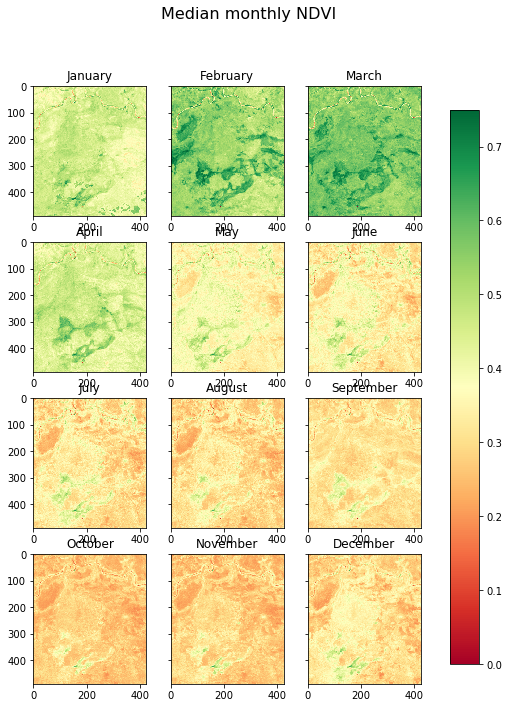

In [241]:
# Initialise the figure
fig, ax_array = plt.subplots(4,3, figsize = (8,11), sharey = True)

# Colour settings
grid_settings = {'cmap':'RdYlGn', 'vmin': 0, 'vmax': 0.75}

fig.suptitle('Median monthly NDVI', fontsize = 16)
# Iterate through the months
for i in range(12):
    # Assign subplots
    row,col = int(i/3), i%3
    
    #PLot image
    month_ndvi = ndvi.groupby('time.month').median(dim = 'time').isel(month = i)
    
    im = ax_array[row, col].imshow(month_ndvi[::-1], **grid_settings)
    # Add title
    ax_array[row, col].set_title(mnths[i + 1])

# Add colourbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
    
plt.show()

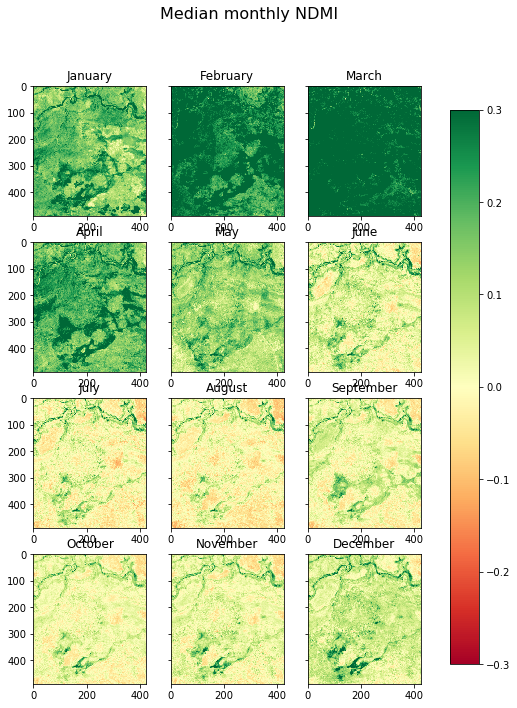

In [242]:
# Initialise the figure
fig, ax_array = plt.subplots(4,3, figsize = (8,11), sharey = True)

# Colour settings
grid_settings = {'cmap':'RdYlGn', 'vmin': -0.30, 'vmax': 0.3}

fig.suptitle('Median monthly NDMI', fontsize = 16)
# Iterate through the months
for i in range(12):
    # Assign subplots
    row,col = int(i/3), i%3
    
    #PLot image
    month_ndmi = ndmi.groupby('time.month').median(dim = 'time').isel(month = i)
    
    im = ax_array[row, col].imshow(month_ndmi[::-1], **grid_settings)
    # Add title
    ax_array[row, col].set_title(mnths[i + 1])

# Add colourbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
    
plt.show()

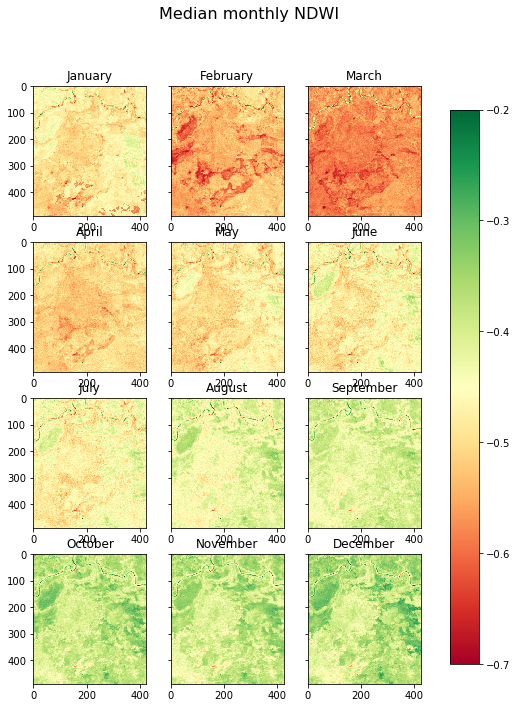

In [243]:
# Initialise the figure
fig, ax_array = plt.subplots(4,3, figsize = (8,11), sharey = True)

# Colour settings
grid_settings = {'cmap':'RdYlGn', 'vmin': -0.7, 'vmax': -0.2}

fig.suptitle('Median monthly NDWI', fontsize = 16)
# Iterate through the months
for i in range(12):
    # Assign subplots
    row,col = int(i/3), i%3
    
    #PLot image
    month_ndwi = ndwi.groupby('time.month').median(dim = 'time').isel(month = i)
    
    im = ax_array[row, col].imshow(month_ndwi[::-1], **grid_settings)
    # Add title
    ax_array[row, col].set_title(mnths[i + 1])

# Add colourbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
    
plt.show()

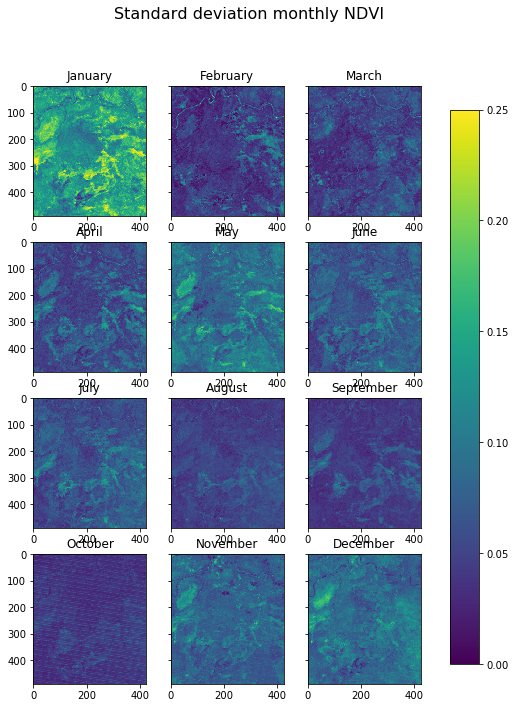

In [244]:
# Initialise the figure
fig, ax_array = plt.subplots(4,3, figsize = (8,11), sharey = True)

# Colour settings
grid_settings = {'cmap':'viridis', 'vmin': 0, 'vmax': 0.25}

fig.suptitle('Standard deviation monthly NDVI', fontsize = 16)
# Iterate through the months
for i in range(12):
    row,col = int(i/3), i%3
    
    #PLot image
    month_std_ndvi = ndvi.groupby('time.month').std(dim = 'time').isel(month = i)

    im = ax_array[row, col].imshow(month_std_ndvi[::-1],
                       **grid_settings)
    ax_array[row, col].set_title(mnths[i + 1])

    
# Add colourbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

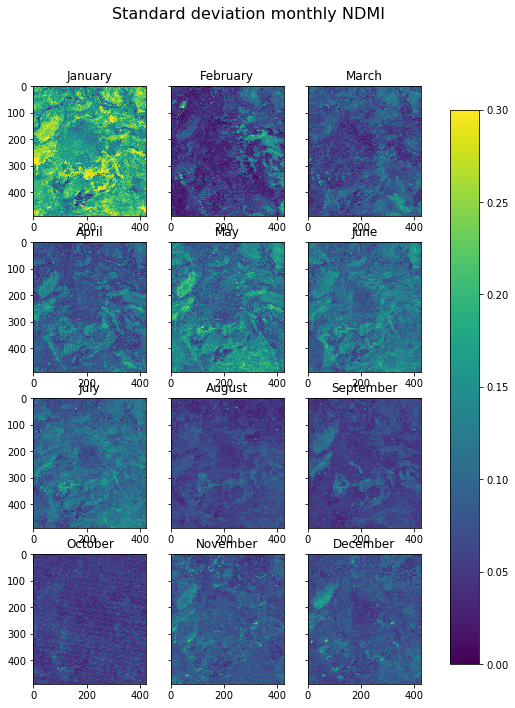

In [245]:
# Initialise the figure
fig, ax_array = plt.subplots(4,3, figsize = (8,11), sharey = True)

# Colour settings
grid_settings = {'cmap':'viridis', 'vmin': 0, 'vmax': 0.3}

fig.suptitle('Standard deviation monthly NDMI', fontsize = 16)
# Iterate through the months
for i in range(12):
    row,col = int(i/3), i%3
    
    #PLot image
    month_std_ndmi = ndmi.groupby('time.month').std(dim = 'time').isel(month = i)

    im = ax_array[row, col].imshow(month_std_ndmi[::-1],
                       **grid_settings)
    ax_array[row, col].set_title(mnths[i + 1])

    
# Add colourbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

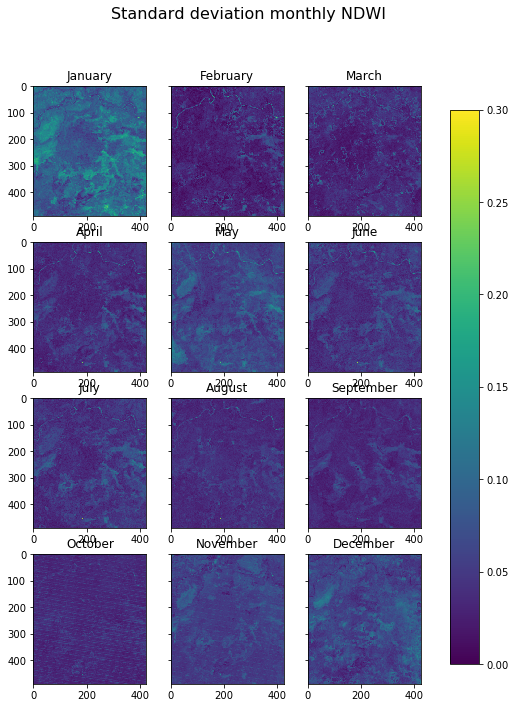

In [246]:
# Initialise the figure
fig, ax_array = plt.subplots(4,3, figsize = (8,11), sharey = True)

# Colour settings
grid_settings = {'cmap':'viridis', 'vmin': 0, 'vmax': 0.3}

fig.suptitle('Standard deviation monthly NDWI', fontsize = 16)
# Iterate through the months
for i in range(12):
    row,col = int(i/3), i%3
    
    #PLot image
    month_std_ndwi = ndwi.groupby('time.month').std(dim = 'time').isel(month = i)

    im = ax_array[row, col].imshow(month_std_ndwi[::-1],
                       **grid_settings)
    ax_array[row, col].set_title(mnths[i + 1])

    
# Add colourbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## Run trend analysis

From the median plots it appears that the vegetation condition declines from about April until January. This is somewhat counter intuitive given that we expect rains in December January. The very high standard deviation in the wet months suggest we may be getting some influence of spurious measurements, perhaps from cloud shadow and/ or surface water.

From this we decide the best way to test vegetation is to use April to November. UB looking at figures, more July - November (so 7 - 11)

In [247]:
# We group the data by dry season for NDVI

#dry_months = [4,5,6,7,8,9,10,1]
dry_months = [7,8,9,10,11]

#REtrieve the dry months
ndvi_dryT = ndvi[ndvi['time.month'].isin(dry_months)]
ndvi_dry = ndvi_dryT.groupby('time.month').median(dim = 'time')
ndvi_dry


<xarray.DataArray (month: 5, y: 489, x: 425)>
array([[[0.309628, 0.299876, ..., 0.330964, 0.335548],
        [0.295528, 0.272319, ..., 0.350038, 0.349838],
        ...,
        [0.288288, 0.268425, ..., 0.276024, 0.243972],
        [0.28917 , 0.280457, ..., 0.240216, 0.228415]],

       [[0.265226, 0.281316, ..., 0.320532, 0.320769],
        [0.262802, 0.262687, ..., 0.337299, 0.331058],
        ...,
        [0.269135, 0.275527, ..., 0.26123 , 0.251748],
        [0.278925, 0.27165 , ..., 0.239138, 0.232445]],

       ...,

       [[0.261026, 0.259612, ..., 0.304702, 0.300524],
        [0.250087, 0.243469, ..., 0.316774, 0.315499],
        ...,
        [0.236921, 0.244906, ..., 0.243432, 0.231118],
        [0.244798, 0.245027, ..., 0.223566, 0.220964]],

       [[0.257024, 0.261594, ..., 0.317254, 0.311865],
        [0.249728, 0.244915, ..., 0.32885 , 0.313959],
        ...,
        [0.243083, 0.248291, ..., 0.232847, 0.222665],
        [0.240516, 0.239652, ..., 0.216488, 0.215288]]], d

In [248]:
#to extract out median NDVI image, need to have individual values, not time based
ndvi_dry2 = ndvi_dryT.median(dim = 'time')
ndvi_dry2

<xarray.DataArray (y: 489, x: 425)>
array([[0.268191, 0.274286, 0.266243, ..., 0.340484, 0.325281, 0.314718],
       [0.255627, 0.252577, 0.258264, ..., 0.315093, 0.331277, 0.325576],
       [0.255627, 0.258746, 0.257143, ..., 0.315093, 0.315464, 0.307732],
       ...,
       [0.248653, 0.254659, 0.276732, ..., 0.252152, 0.255608, 0.266583],
       [0.254047, 0.263004, 0.284234, ..., 0.239502, 0.248666, 0.240138],
       [0.265982, 0.264628, 0.280259, ..., 0.233246, 0.231792, 0.225585]],
      dtype=float32)
Coordinates:
  * y        (y) float64 7.811e+06 7.811e+06 7.811e+06 ... 7.824e+06 7.824e+06
  * x        (x) float64 3.239e+05 3.239e+05 3.239e+05 ... 3.345e+05 3.345e+05

In [249]:
# We group the data by dry season for NDMI

#dry_months = [4,5,6,7,8,9,10,11]
dry_months = [7,8,9,10,11]

#REtrieve the dry months
ndmi_dryT = ndmi[ndmi['time.month'].isin(dry_months)]
ndmi_dry = ndmi_dryT.groupby('time.month').median(dim = 'time')


In [250]:
#to extract out median NDVI image, need to have individual values, not time based
ndmi_dry2 = ndmi_dryT.median(dim = 'time')
ndmi_dry2

<xarray.DataArray (y: 489, x: 425)>
array([[-0.063907, -0.065354, -0.087014, ...,  0.051326,  0.034274,  0.012154],
       [-0.081334, -0.093347, -0.09236 , ...,  0.025681,  0.039424,  0.030027],
       [-0.081334, -0.0825  , -0.081996, ...,  0.02503 ,  0.010662, -0.009129],
       ...,
       [ 0.021343,  0.025073,  0.045408, ..., -0.06052 , -0.063023, -0.054868],
       [ 0.022631,  0.02707 ,  0.056372, ..., -0.076957, -0.068602, -0.067792],
       [ 0.028556,  0.031795,  0.04752 , ..., -0.076036, -0.070501, -0.081789]],
      dtype=float32)
Coordinates:
  * y        (y) float64 7.811e+06 7.811e+06 7.811e+06 ... 7.824e+06 7.824e+06
  * x        (x) float64 3.239e+05 3.239e+05 3.239e+05 ... 3.345e+05 3.345e+05

In [251]:
# We group the data by dry season for NDWI

#dry_months = [4,5,6,7,8,9,10,11]
dry_months = [7,8,9,10,11]

#REtrieve the dry months
ndwi_dry = ndwi[ndwi['time.month'].isin(dry_months)]
ndwi_dry = ndwi_dry.groupby('time.month').median(dim = 'time')


In [252]:
# Run the linear regression on the monthly ndvi
NDVIcov,NDVIcor,NDVIslope,NDVIintercept,NDVIpval,NDVIstderr,NDVIsd = linregress_3D(ndvi_dry.month, ndvi_dry)

In [253]:
# Run the linear regression on the monthly ndmi
NDMIcov,NDMIcor,NDMIslope,NDMIintercept,NDMIpval,NDMIstderr, NDMIsd = linregress_3D(ndmi_dry.month, ndmi_dry)

In [254]:
# Run the linear regression on the monthly ndwi
NDWIcov,NDWIcor,NDWIslope,NDWIintercept,NDWIpval,NDWIstderr, NDWIsd = linregress_3D(ndwi_dry.month, ndwi_dry)

From these plots it appears that most of the veg communities have a negative slope (i.e. declining NDVI/ vegetation condition). High r-squared values suggest a strong linear relationship in these areas. However there is a spring/vegetation at the bottom ~(327875,7813000) with a positive or small negative slope and a low-rsquared. We conclude that these communities retain their condition during the dry season and thus have a greater probability of groundwater dependence.

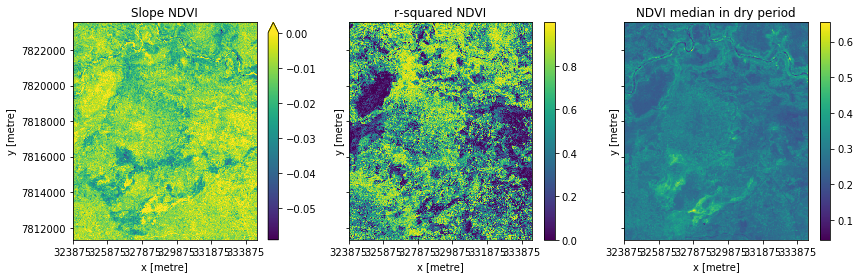

In [255]:
# View the slope and correlation coefficient for NDVI
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (14,4),
                              sharey = True, sharex = True)


NDVIim1 = NDVIslope.plot(ax = ax1, vmin = NDVIslope.min(),
                vmax = 0)
ax1.set_title('Slope NDVI')


NDVIr_squ = NDVIcor**2

NDVIim2 = NDVIr_squ.plot(ax = ax2)
ax2.set_title('r-squared NDVI')

# Better
ax1.xaxis.set_ticks(np.arange(ax1.get_xlim()[0],
                    ax1.get_xlim()[-1],2000))

NDVIim3 = ndvi_dry2.plot(ax = ax3, vmin = ndvi_dry2.min(), vmax = ndvi_dry2.max())
ax3.set_title('NDVI median in dry period')


plt.show()

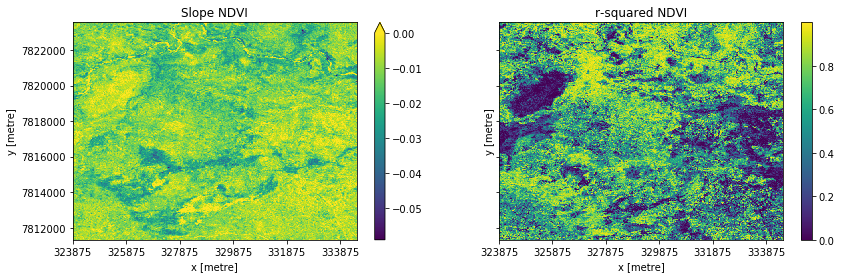

In [256]:
# View the slope and correlation coefficient for NDVI
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,4),
                              sharey = True, sharex = True)


NDVIim1 = NDVIslope.plot(ax = ax1, vmin = NDVIslope.min(),
                vmax = 0)
ax1.set_title('Slope NDVI')


NDVIr_squ = NDVIcor**2

NDVIim2 = NDVIr_squ.plot(ax = ax2)
ax2.set_title('r-squared NDVI')

# Better
ax1.xaxis.set_ticks(np.arange(ax1.get_xlim()[0],
                    ax1.get_xlim()[-1],2000))

plt.show()

From these plots it appears that most of this area has a negative slope (i.e. declining NDMI/ moisture). High r-squared values suggest a strong linear relationship in these areas. However there is an area at the bottom ~(327875,7813000) with a positive or small negative slope and a low-rsquared. We conclude that this area retains moisture during the dry season and thus have a greater probability of influence from groundwater.

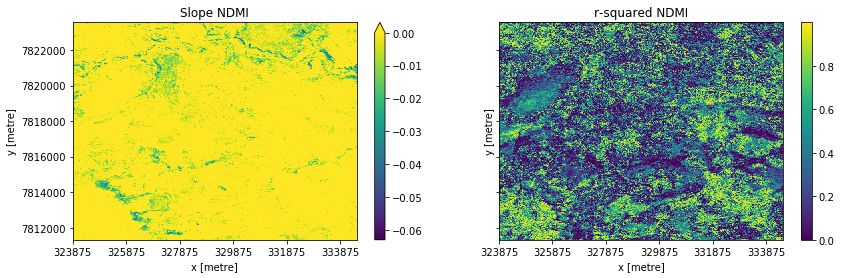

In [257]:
# View the slope and correlation coefficient for NDMI
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,4),
                              sharey = True, sharex = True)


NDMIim1 = NDMIslope.plot(ax = ax1, vmin = NDMIslope.min(),
                vmax = 0)
ax1.set_title('Slope NDMI')


NDMIr_squ = NDMIcor**2

NDMIim2 = NDMIr_squ.plot(ax = ax2)
ax2.set_title('r-squared NDMI')

# Better
ax1.xaxis.set_ticks(np.arange(ax1.get_xlim()[0],
                    ax1.get_xlim()[-1],2000))


plt.show()

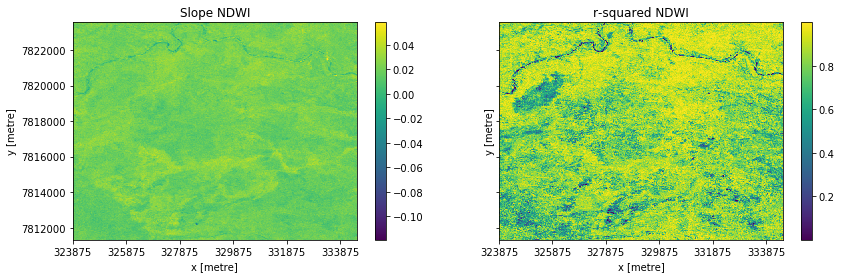

In [258]:
# View the slope and correlation coefficient for NDWI
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,4),
                              sharey = True, sharex = True)

NDWIslope.min(),
NDWIim1 = NDWIslope.plot(ax = ax1, vmin = NDWIslope.min(),
                vmax = NDWIslope.max())
ax1.set_title('Slope NDWI')


NDWIr_squ = NDWIcor**2

NDWIim2 = NDWIr_squ.plot(ax = ax2)
ax2.set_title('r-squared NDWI')

# Better
ax1.xaxis.set_ticks(np.arange(ax1.get_xlim()[0],
                    ax1.get_xlim()[-1],2000))


plt.show()

In [259]:
NDMIim1

### Exporting out NDVI image with 3 bands (slope, r squared, NDVI median value for dry period

In [260]:
startDate = str(ls578_ds.isel(time=0).time.values)[0:10]
endDate = str(ls578_ds.isel(time=-1).time.values)[0:10]
#endDate[0:4] + " " + endDate
#print ("NDVI of dry period (months " + str(dry_months[0])+ "-"+str(dry_months[-1]) + " from "+startDate+" to " +endDate)
#print ('NDVI_landsat_dry_'+startDate+'_'+endDate[0:4]+'.tif')

In [261]:
#Export out NDVI values, slope and r-squared for dry period specified

#set variable for path to save files
savefilepath = '/g/data/zk34/pxk547/'

#Exporting NDVI slope into new dataset
NDVIslopeDS = NDVIslope.to_dataset(name='NDVI_slope')

# We can now add other attributes (Rsquared) into our dataset as new data variables (can't add NDVI as has monthly values):

NDVIslopeDS["NDVI_rsqu"] = NDVIr_squ
NDVIslopeDS["NDVI_dry_median"] = ndvi_dry2
NDVIslopeDS["NDVI_sd"] = NDVIsd
#NDVIslopeDS

#converting type from float64 to float32 to reduce file size
NDVIslopeDS = NDVIslopeDS.astype(np.float32)
#Adding CRS back into dataset
NDVIslopeDS.attrs = ls578_ds.attrs
#print (NDVIslopeDS)


#this writes the geotiff with 3 bands: NDVI_slope, NDVI-rsqu, NDVI_dry_median
write_geotiff(savefilepath+'NDVI_landsat_dry_'+str(dry_months[0])+ "_"+str(dry_months[-1])+'_'+startDate[0:4]+'_'+endDate[0:4]+'.tif', NDVIslopeDS)
print(savefilepath+'NDVI_landsat_dry_'+str(dry_months[0])+ "_"+str(dry_months[-1])+'_'+startDate[0:4]+'_'+endDate[0:4]+'.tif has been saved')

#creating metadata file for NDVI_landsat_dry.tif
print ('your metadata file is being created')
f = open(savefilepath+'NDVI_landsat_dry_'+str(dry_months[0])+ "_"+str(dry_months[-1])+'_'+startDate[0:4]+'_'+endDate[0:4]+'.txt','w')  #w - writes, r - reads; a- appends

f.write("NDVI of dry period (months " + str(dry_months[0])+ "-"+str(dry_months[-1]) + " from "+startDate+" to " +endDate+ "\n" +
        "NDVI_slope, NDVI_rsqu and NDVI_dry_median are the 3 bands. " + "\n" +
        "Where slope is 0 is where NDVI values don't change much during the dry period. " + "\n" + 
        "Where rsqu is 1 is where correlation is high between months, therefore no variation "+ "\n" + 
        "Ndvi_dry_median is the median value of NDVI over the dry months"+ "\n" +
        "Can use the ndvi value to select where areas are green and intersect those "+ "\n" +
         "where slope is near 0 to find potential GDV sites.")
f.write(str(ds)) #if don't have text to hand, could use this
f.close()
print ("NDVI_landsat_dry_"+str(dry_months[0])+ "_"+str(dry_months[-1]) +'_'+ startDate[0:4]+'_'+endDate[0:4]+".txt has been saved to "+savefilepath)

/g/data/zk34/pxk547/NDVI_landsat_dry_7_11_2000_2009.tif has been saved
your metadata file is being created
NDVI_landsat_dry_7_11_2000_2009.txt has been saved to /g/data/zk34/pxk547/


### Exporting out NDMI image with 3 bands (slope, r squared, NDVI median value for dry period

In [262]:
#Exporting NDMI slope
NDMIslopeDS = NDMIslope.to_dataset(name='slope')

# We can now add other attributes (Rsquared) into our dataset as new data variables (can't add NDVI as has monthly values):

NDMIslopeDS["NDMI_rsqu"] = NDMIr_squ
NDMIslopeDS["NDMI_dry_median"] = ndmi_dry2

#converting type from float64 to float32 to reduce file size
NDMIslopeDS = NDMIslopeDS.astype(np.float32)
#Adding CRS back into dataset
NDMIslopeDS.attrs = ls578_ds.attrs
#NDMIslopeDS

#set variable for path to save files
savefilepath = '/g/data/zk34/pxk547/'

#this writes the geotiff with 3 bands: NDVI_slope, NDVI-rsqu, NDVI_dry_median
write_geotiff(savefilepath+'NDMI_landsat_dry_'+str(dry_months[0])+ "_"+str(dry_months[-1])+'_'+startDate[0:4]+'_'+endDate[0:4]+'.tif', NDMIslopeDS)
print(savefilepath+'NDMI_landsat_dry_'+str(dry_months[0])+ "_"+str(dry_months[-1])+'_'+startDate[0:4]+'_'+endDate[0:4]+'.tif has been saved')

#creating metadata file for Barest Earth using same name as tif
print ('your metadata file is being created')
f = open(savefilepath+'NDMI_landsat_dry_'+str(dry_months[0])+ "_"+str(dry_months[-1])+'_'+startDate[0:4]+'_'+endDate[0:4]+'.txt','w')   #w - writes, r - reads; a- appends

f.write("NDMI of dry period (months " + str(dry_months[0])+ "-"+str(dry_months[-1]) + " from "+startDate+" to " +endDate+ "\n" +
        "Where slope is 0 is where NDMI values don't change much during the dry period. " + "\n" + 
        "Where rsqu is 1 is where correlation is high between months, therefore no variation "+ "\n" + 
        "NDMI_dry_median is the median value of NDMI over the dry months"+ "\n" +
        "Can use the ndmi value to select where areas are wet and intersect those "+ "\n" +
         "where slope is near 0 to find potential permanently wet sites.")
f.write(str(ds)) #if don't have text to hand, could use this
f.close()
print ("NDMI_landsat_dry_"+str(dry_months[0])+ "_"+str(dry_months[-1]) +'_'+ startDate[0:4]+'_'+endDate[0:4]+".txt has been saved to "+savefilepath)

/g/data/zk34/pxk547/NDMI_landsat_dry_7_11_2000_2009.tif has been saved
your metadata file is being created
NDMI_landsat_dry_7_11_2000_2009.txt has been saved to /g/data/zk34/pxk547/


R-squared for high dry season NDVI recession =  0.9427384429107939
LR slope for high dry season NDVI recession =  -0.023760334083012175
R-squared for low dry season NDVI recession =  0.18486782649714698
LR slope for low dry season NDVI recession =  -0.005572195563997542


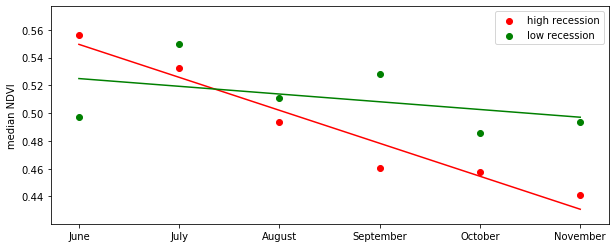

In [67]:
# To illustrate this we plot the points and regression slope for NDVI

fig, (ax1) = plt.subplots(1, figsize = (10,4), sharey = True)

# First pixel is in the high recession veg community

scatter_kwargs = {'c': 'r','label': 'high recession'}
plot_kwargs = {'c': 'r'}

#x,y = 326750 , 7816000   #spring that dries out near below spring
x,y = 332830 , 7822345   #forest pocket that dries out above river
#x,y = 327897,7812820   #trees below spring outside area picked up


regression_pixel_drill_ndvi(x,y, ax1, NDVIslope, NDVIintercept, scatter_kwargs = scatter_kwargs,
                       plot_kwargs = plot_kwargs)

print('R-squared for high dry season NDVI recession = ', NDVIr_squ.sel(x = x, y = y,
                       method = 'nearest').values)
print ('LR slope for high dry season NDVI recession = ',NDVIslope.sel(x =x, y=y, method = 'nearest').values)

# Second pixel is in low recession veg community

scatter_kwargs = {'c': 'g','label': 'low recession'}
plot_kwargs = {'c': 'g'}

#x,y = 326164,7818354   # sus wet area think being picked up in images above  (NDVI constant as bare area)
x,y = 327875,7813000  #spring that is generally wet/green most of the time (0.2 here, but 0.9 in sentinel)
#x,y = 328666,7812409  #area below above spring, checking if green most of time as R bit higher than above
#x,y = 329174,7812965   #clump of trees just to the east of spring above
#x,y = 328145,7812795  #trees below spring between 0.02 and 0.03 slope, to see what slope looks like compared to high recession
#x,y =  3280206,7812831  #trees near above that didn't come up with high R2, low slope etc
#x,y =  328185,7812846 #trees near above that did have right criteria
#x,y =  328206,7812815 #trees near above that did have right criteria
#x,y = 395300,7814787   #green part of oval (when R2 is low means high correlation - points all over the place, so low R2 is not GDV)



regression_pixel_drill_ndvi(x,y, ax1, NDVIslope, NDVIintercept, scatter_kwargs = scatter_kwargs,
                       plot_kwargs = plot_kwargs)

print('R-squared for low dry season NDVI recession = ', NDVIr_squ.sel(x = x, y = y,
                       method = 'nearest').values)
print ('LR slope for low dry season NDVI recession = ',NDVIslope.sel(x =x, y=y, method = 'nearest').values)

ax1.set_xticklabels([mnths[n] for n in ax1.get_xticks()])

ax1.set_ylabel('median NDVI')

ax1.legend()



R-squared for high dry season NDMI recession =  0.6642060531688679
R-squared for low dry season NDMI recession =  0.07589760030153275
Slope for low dry season NDVI recession =  -0.003581533261707851


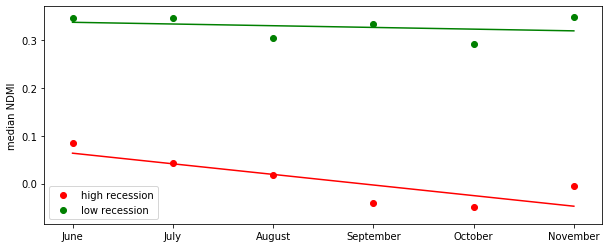

In [61]:
# To illustrate this we plot the points and regression slope for NDMI 
fig, (ax1) = plt.subplots(1, figsize = (10,4), sharey = True)

# First pixel is in the high recession veg community

scatter_kwargs = {'c': 'r','label': 'high recession'}
plot_kwargs = {'c': 'r'}

x,y = 358530,7795865     #middle of old lake, not sure if fills anymore
#x,y = 326750 , 7816000   #spring that dries out near below spring
#x,y = 332830 , 7822345   #forest pocket that dries out above river

regression_pixel_drill_ndmi(x,y, ax1, NDMIslope, NDMIintercept, scatter_kwargs = scatter_kwargs,
                       plot_kwargs = plot_kwargs)

print('R-squared for high dry season NDMI recession = ', NDMIr_squ.sel(x = x, y = y,
                       method = 'nearest').values)

# Second pixel is in low recession veg community

scatter_kwargs = {'c': 'g','label': 'low recession'}
plot_kwargs = {'c': 'g'}


#x,y = 326164,7818354  # sus wet area think being picked up in images above  (NDVI constant as bare area); think it's cracking clay, and not as wet as spring
x,y = 327875,7813000  #spring that is generally wet/green most of the time

regression_pixel_drill_ndmi(x,y, ax1, NDMIslope, NDMIintercept, scatter_kwargs = scatter_kwargs,
                       plot_kwargs = plot_kwargs)

print('R-squared for low dry season NDMI recession = ', NDMIr_squ.sel(x = x, y = y,
                       method = 'nearest').values)

print ('Slope for low dry season NDVI recession = ',NDMIslope.sel(x =x, y=y, method = 'nearest').values)

ax1.set_xticklabels([mnths[n] for n in ax1.get_xticks()])

ax1.set_ylabel('median NDMI')

ax1.legend()



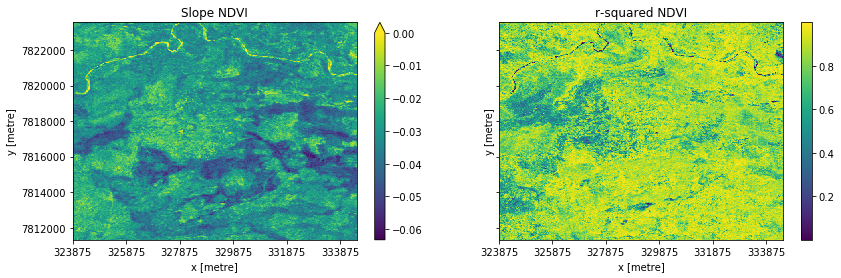

In [41]:
# View the slope and correlation coefficient for NDMI
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,4),
                              sharey = True, sharex = True)


NDVIim1 = NDVIslope.plot(ax = ax1, vmin = NDVIslope.min(),
                vmax = 0)
ax1.set_title('Slope NDVI')


NDVIr_squ = NDVIcor**2

NDVIim2 = NDVIr_squ.plot(ax = ax2)
ax2.set_title('r-squared NDVI')

# Better
ax1.xaxis.set_ticks(np.arange(ax1.get_xlim()[0],
                    ax1.get_xlim()[-1],2000))


plt.show()

R-squared for high dry season NDWI recession =  0.8573760969158589
R-squared for low dry season NDWI recession =  0.5769742890413465


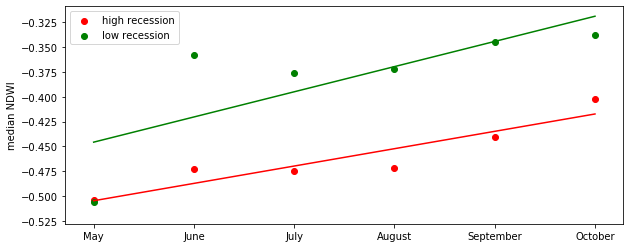

In [42]:
# To illustrate this we plot the points and regression slope for NDVI

fig, (ax1) = plt.subplots(1, figsize = (10,4), sharey = True)

# First pixel is in the high recession veg community

scatter_kwargs = {'c': 'r','label': 'high recession'}
plot_kwargs = {'c': 'r'}

#x,y = 358530,7795865     #middle of old lake, not sure if fills anymore
x,y = 326750 , 7816000   #spring that dries out near below spring
#x,y = 332830 , 7822345   #forest pocket that dries out above river

regression_pixel_drill_ndwi(x,y, ax1, NDWIslope, NDWIintercept, scatter_kwargs = scatter_kwargs,
                       plot_kwargs = plot_kwargs)

print('R-squared for high dry season NDWI recession = ', NDWIr_squ.sel(x = x, y = y,
                       method = 'nearest').values)

# Second pixel is in low recession veg community

scatter_kwargs = {'c': 'g','label': 'low recession'}
plot_kwargs = {'c': 'g'}

#x,y = 357343,7795191        #lake, to check what values water is getting
x,y = 326164,7818354   # sus wet area think being picked up in images above  (NDVI constant as bare area)
#x,y = 327875,7813000  #spring that is generally wet/green most of the time
#x,y = 319900,7806104

regression_pixel_drill_ndwi(x,y, ax1, NDWIslope, NDWIintercept, scatter_kwargs = scatter_kwargs,
                       plot_kwargs = plot_kwargs)

print('R-squared for low dry season NDWI recession = ', NDWIr_squ.sel(x = x, y = y,
                       method = 'nearest').values)

ax1.set_xticklabels([mnths[n] for n in ax1.get_xticks()])

ax1.set_ylabel('median NDWI')

ax1.legend()



In [6]:
ax1.get_xticks()

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

## Conclusion

Our conclusion from this investigation is that there are vegetation communities in the area of interest that appear to that show statistically negligible change in condition despite prolonged dry conditions. In contrast, adjacent vegetation communities decline linearly throughout the dry season as soil moisture becomes scarce. We hypothesise that the lack of recession is due to the availability of groundwater within the root zones throughout the dry season. Follow up work including field observations and chemistry are required to validate this.